<a href="https://colab.research.google.com/github/XQuyTran/APP-CQ18/blob/main/notebook/B%E1%BA%A3n_sao_c%E1%BB%A7a_PlantDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%cd /content/drive/MyDrive/plant-pathology-2020-fgvc7/

/content/drive/MyDrive/plant-pathology-2020-fgvc7


In [ ]:
from math import e
import pandas as pd
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [ ]:
train_table = pd.read_csv('train.csv')
test_table = pd.read_csv('test.csv')

### Khám phá dữ liệu

In [ ]:
train_table.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


- Số dòng, số cột của dữ liệu?

In [ ]:
train_table.shape

(1821, 5)

- Kiểu dữ liệu ?




In [ ]:
train_table.dtypes

image_id             object
healthy               int64
multiple_diseases     int64
rust                  int64
scab                  int64
dtype: object

- Có ảnh nào bị trùng không ?

In [ ]:
train_table.index.duplicated().sum()

0

- Phân bố dữ liệu trong cùng một lớp?

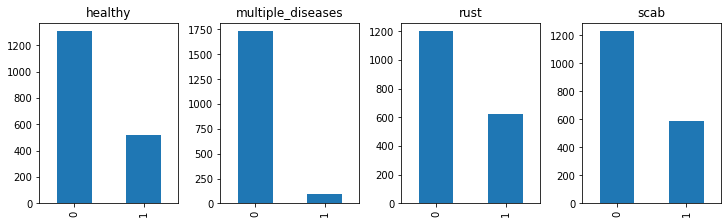

In [ ]:
LABELS = ["healthy", "multiple_diseases", "rust", "scab"]
_, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column in zip(axes, LABELS):
   train_table[column].value_counts().plot.bar(title=column, ax=ax)
plt.show()

- Tỉ lệ dữ liệu giữa các lớp?

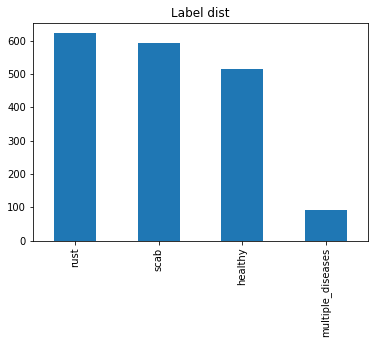

In [ ]:
# ADD
plt.title('Label dist')
train_table[LABELS].idxmax(axis=1).value_counts().plot.bar()

## 1. Trích xuất dữ liệu màu sắc và huấn luyện mô hình mạng neuron với 1 layer ẩn và activation là hàm softmax

### 1.1 Trực quan hoá các hình ảnh về bênh tật để đưa ra kết luận

In [ ]:
def getSampleToShow(keyColumn, sample):
    list_sample_image = []
    sample_train = train_table[train_table[keyColumn] == 1].sample(n = sample)
    for image_id in sample_train['image_id']:
        name = "images/" + image_id + ".jpg"
        image = cv.imread(name)
        im_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        list_sample_image.append(im_rgb)
    return np.array(list_sample_image)

def showImages(images):
    plt.figure(figsize=(15,15))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        
def getImageToTest():
    return cv.imread("images/Train_382.jpg")

#### Hình ảnh từ sample của class rust

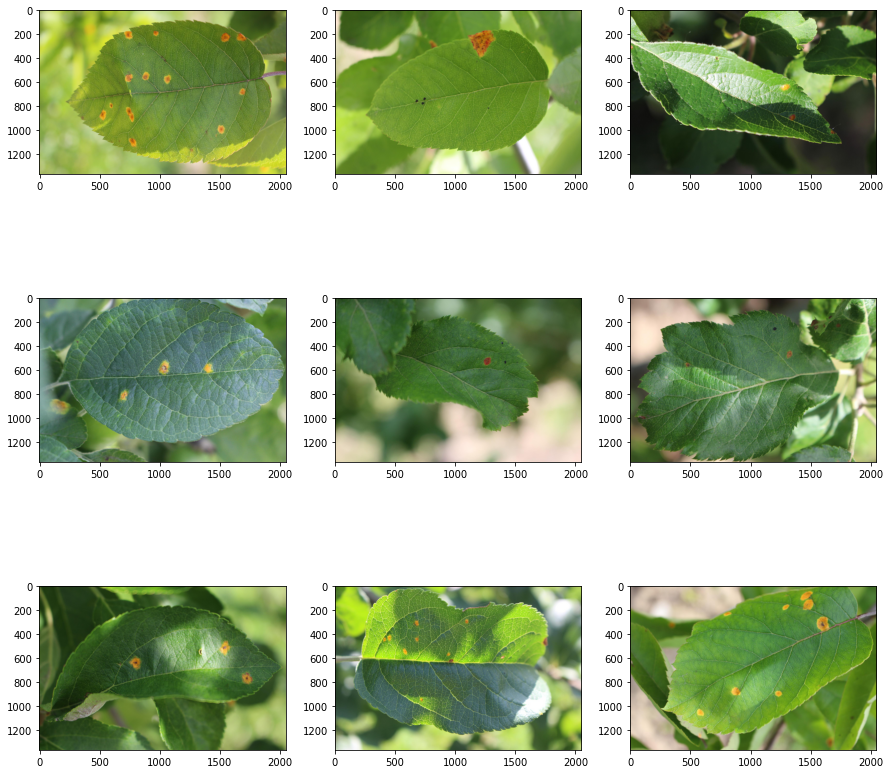

In [ ]:
# Xuat ra anh cua class rust
rust_iamges = getSampleToShow('rust', 9)
showImages(rust_iamges)

#### Hình ảnh từ sample của class scab

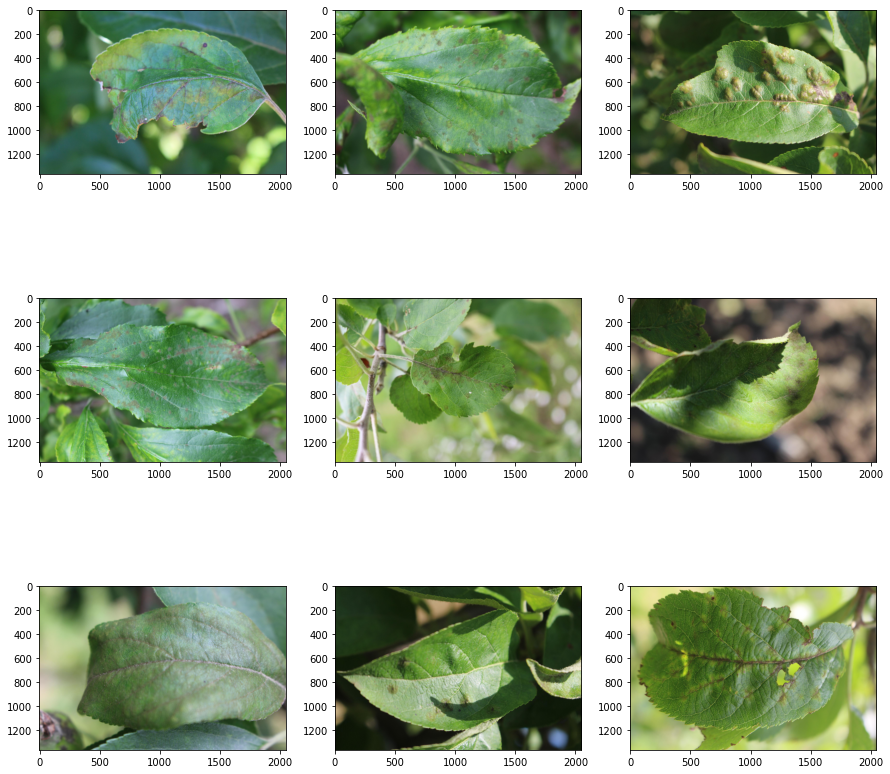

In [ ]:
# Xuat ra anh cua class scab
rust_iamges = getSampleToShow('scab', 9)
showImages(rust_iamges)

#### Kết luận:
- Ở đây chúng ta có thể thấy rằng ở class rust thì lá thường sẽ có màu các đốm màu vàng và class scab thì thường sẽ có các đốm màu đen.
- Từ đó vấn đề về màu sắc là một thuộc tính rõ ràng để chúng ta trích xuất dữ liệu cho các class này
- Vậy nên chúng em quyết định chọn 2 figure chính cho model thứ nhất này là color histogram và hue monents hai figure liên quan đến màu sắc.

#### Vấn đề gặp phải:
- Bachground của các ảnh chứa quá nhiều chi tiết về màu sắc thừa cần phải loại bỏ những chi tiết này để mô hình có thể dự đoán tốt hơn.

### 1.2 Tìm ra một số hàm để trích xuất background của ảnh.

#### 1.2.1 Load một ảnh để trích xuất

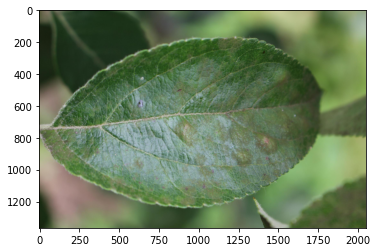

In [ ]:
image = getImageToTest()
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

#### 1.2.2 Sử dụng đạo hàm ảnh bằng phương pháp candy

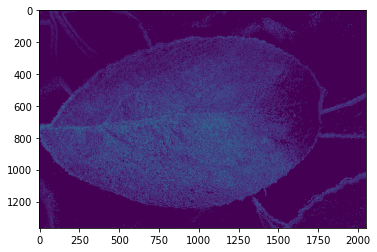

In [ ]:
def applyCannyThreshold( frame, val):
    ratio = 1.2
    kernel_size = 3
    low_threshold = val
    img_blur = cv.GaussianBlur(frame, (3, 3), 0)
    detected_edges = cv.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)
    mask = detected_edges != 0
    dst = frame * (mask[:,:].astype(frame.dtype))
    return dst

gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
drivative_image = applyCannyThreshold(gray_image, 12)
plt.imshow(drivative_image)

- Sau khi lấy đạo hàm ảnh thì chúng ta có thể thấy các chi tiết của lá được dữ lại khá nhiều với lá ở chính giữa với threshold là 10

#### 1.2.3 Sử dụng phương pháp nén ảnh với threshold và liên kết các ô xung quanh để lấp khuyết ảnh.

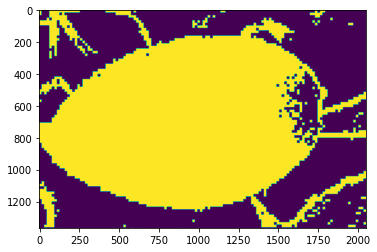

In [ ]:
# Hàm dùng để nén ảnh với threshold là ratio sẽ trả ra kết quả là ảnh với block tương ứng với zip x zip
# và nếu block nào không đủ pixel yêu cầu thì là 0 còn ngược lại thì là 1
def zipImage(src, zip_x, zip_y, ratio):
    rs, cs = src.shape
    zip_rs = int(rs / zip_y)
    zip_cs = int(cs / zip_x)
    
    for idx in range(0, zip_rs * zip_y, zip_y):
        for jdx in range(0, zip_cs * zip_x, zip_x):
            block_img = src[idx : idx + zip_y, jdx : jdx + zip_x]
            num_pixel = np.sum(block_img > 0)
            if num_pixel >= zip_x*zip_y * ratio:
                block_img[:,:] = 1
            else:
                block_img[:,:] = 0

    return src

mask_image = zipImage(drivative_image, 8, 8, 0.12)
mask_image = zipImage(mask_image, 16, 16, 0.2)

plt.imshow(mask_image * 255)

- Kết quả của ảnh test sau khi được nén và lấy theo tỉ lệ threshold.

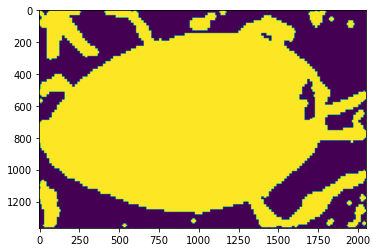

In [ ]:
# Hàm dùng để liên kết các ô xung quanh để lấp khuyết sẽ trả ra kết quả là một ma trận mask
def joinNeiboorPixel(src, zip_x, zip_y, mask_size, ratio):
    rs, cs = src.shape
    zip_rs = int(rs / zip_y)
    zip_cs = int(cs / zip_x)
    half = int(mask_size / 2)
    dst = src.copy()
    for idx in range(half , zip_rs - half):
        for jdx in range(half, zip_cs - half):
            start_row_mask = (idx - half ) * zip_y
            end_row_mask = (idx + half + 1) * zip_y
            start_col_mask = (jdx - half) * zip_x
            end_col_mask = (jdx + half + 1) * zip_x
            mask_block = src[start_row_mask : end_row_mask, start_col_mask : end_col_mask]
            block_img = dst[idx * zip_y : (idx + 1) * zip_y, jdx * zip_x : (jdx + 1) * zip_x]
            num_pixel = np.sum(mask_block > 0)
            if num_pixel >= mask_size * mask_size * zip_x * zip_y * ratio:
                block_img[:,:] = 1
    return dst

mask_image = joinNeiboorPixel(mask_image, 8, 8, 3, 0.2)
mask_image = joinNeiboorPixel(mask_image, 16, 16, 3, 1 / 3)

plt.imshow(mask_image * 255)

- Kết quả của ảnh test sau khi được lấp đầy.

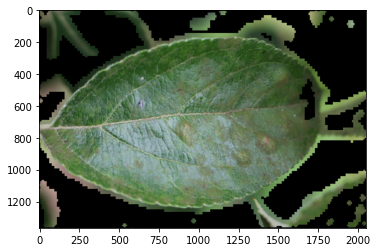

In [ ]:
# Chạy mỗi hàm 2 lần để có một mask nén tốt
# và có sự liên kết giữa các pixel tốt hơn
mask_image = zipImage(drivative_image, 8, 8, 0.12)
mask_image = zipImage(mask_image, 16, 16, 0.2)
mask_image = joinNeiboorPixel(mask_image, 8, 8, 3, 0.2)
mask_image = joinNeiboorPixel(mask_image, 16, 16, 3, 1 / 3)
for chanel in range(0, 3):
    image[:,:,chanel] = image[:,:,chanel] * mask_image

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

- Kết quả sau khi loại bỏ bớt background của anh test đã giữ lại gần như chiếc lá gốc.

#### 1.2.4 Hàm dùng để trích xuất color histogram và hue monents

In [ ]:
def fd_histogram(image, mask=None):
    bins = 8
    # convert the image to HSV color-space
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [1, 256, 1, 256, 1, 256])
    # normalize the histogram
    cv.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

def fd_hu_moments(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    return feature

#### 1.2.5 Hàm để trích xuất tất cả các ảnh ra tập train_data và lưu lại trong file train_data.csv

In [ ]:
def getPathImageById(image_id):
    return "images/" + image_id + ".jpg"

def getFigureForImage(path):
    img = cv.imread(path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (3, 3), 0)
    mask_img = applyCannyThreshold(gray, 12)
    mask_img = zipImage(mask_img, 8, 8, 0.12)
    mask_img = zipImage(mask_img, 16, 16, 0.2)
    mask_img = joinNeiboorPixel(mask_img, 8, 8, 3, 0.15)
    mask_img = joinNeiboorPixel(mask_img, 16, 16, 3, 1 / 3)
    for chanel in range(0, 3):
        img[:,:,chanel] = img[:,:,chanel] * mask_img

    hist_figure = fd_histogram(img).astype(np.float64)
    hu_monents = fd_hu_moments(img)
    fig = np.concatenate((hist_figure, hu_monents))
    return fig

### 1.3 Trích xuất xữ liệu từ dạng ảnh sang dạng số.

In [ ]:
# tạo tên cột cho bảng data mới
def createColsTrainName():
    cols = []
    for i in range(0, 512):
        cols.append('color_hist_' + str(i))

    for i in range(0, 7):
        cols.append('hu_moents_' + str(i))
    
    return cols

# hàm trích xuất data từ ảnh 
def createTrainData(train_table):
    series = train_table['image_id']
    figs = None
    for id in series:
        name = getPathImageById(id)
        fig = getFigureForImage(name)
        if figs is None:
            figs = fig
        else:
            figs = np.vstack((figs, fig))

        print("Da trich xuat xong anh: " + name)
    
    cols = createColsTrainName()
    train_data = pd.DataFrame(figs, columns = cols)
    train_data['image_id'] = train_table['image_id']
    return train_data

In [ ]:
# trích xuất data của bảng train và lưu vào train_data.csv
train_data = createTrainData(train_table)
train_data.to_csv('train_data.csv', index=False)

Da trich xuat xong anh: images/Train_0.jpg
Da trich xuat xong anh: images/Train_1.jpg
Da trich xuat xong anh: images/Train_2.jpg
Da trich xuat xong anh: images/Train_3.jpg
Da trich xuat xong anh: images/Train_4.jpg
Da trich xuat xong anh: images/Train_5.jpg
Da trich xuat xong anh: images/Train_6.jpg
Da trich xuat xong anh: images/Train_7.jpg
Da trich xuat xong anh: images/Train_8.jpg
Da trich xuat xong anh: images/Train_9.jpg
Da trich xuat xong anh: images/Train_10.jpg
Da trich xuat xong anh: images/Train_11.jpg
Da trich xuat xong anh: images/Train_12.jpg
Da trich xuat xong anh: images/Train_13.jpg
Da trich xuat xong anh: images/Train_14.jpg
Da trich xuat xong anh: images/Train_15.jpg
Da trich xuat xong anh: images/Train_16.jpg
Da trich xuat xong anh: images/Train_17.jpg
Da trich xuat xong anh: images/Train_18.jpg
Da trich xuat xong anh: images/Train_19.jpg
Da trich xuat xong anh: images/Train_20.jpg
Da trich xuat xong anh: images/Train_21.jpg
Da trich xuat xong anh: images/Train_22.jp

In [ ]:
# Đọc bảng data train để thực hiện train model
train_data = pd.read_csv('train_data.csv')
train_data.head()

,color_hist_0,color_hist_1,color_hist_2,color_hist_3,color_hist_4,color_hist_5,color_hist_6,color_hist_7,color_hist_8,color_hist_9,color_hist_10,color_hist_11,color_hist_12,color_hist_13,color_hist_14,color_hist_15,color_hist_16,color_hist_17,color_hist_18,color_hist_19,color_hist_20,color_hist_21,color_hist_22,color_hist_23,color_hist_24,color_hist_25,color_hist_26,color_hist_27,color_hist_28,color_hist_29,color_hist_30,color_hist_31,color_hist_32,color_hist_33,color_hist_34,color_hist_35,color_hist_36,color_hist_37,color_hist_38,color_hist_39,...,color_hist_480,color_hist_481,color_hist_482,color_hist_483,color_hist_484,color_hist_485,color_hist_486,color_hist_487,color_hist_488,color_hist_489,color_hist_490,color_hist_491,color_hist_492,color_hist_493,color_hist_494,color_hist_495,color_hist_496,color_hist_497,color_hist_498,color_hist_499,color_hist_500,color_hist_501,color_hist_502,color_hist_503,color_hist_504,color_hist_505,color_hist_506,color_hist_507,color_hist_508,color_hist_509,color_hist_510,color_hist_511,hu_moents_0,hu_moents_1,hu_moents_2,hu_moents_3,hu_moents_4,hu_moents_5,hu_moents_6,image_id
0,0.000002,0.000000,0.000000,0.000000,0.000002,0.000000,0.000143,0.000342,0.000039,0.000074,0.000002,0.000002,0.000013,0.000264,0.001050,0.000825,0.004805,0.005498,0.004491,0.034442,0.064013,0.019100,0.002434,0.000905,0.001674,0.013316,0.051327,0.086137,0.068592,0.011614,0.003651,0.000253,0.0,0.003822,0.015914,0.025853,0.020843,0.012599,0.005517,0.000076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001659,5.359001e-07,3.789961e-10,9.160715e-12,5.393677e-22,6.601966e-15,-2.092071e-23,Train_0
1,0.000000,0.002546,0.007361,0.022016,0.056558,0.037865,0.000858,0.010029,0.000000,0.004300,0.036798,0.037006,0.073348,0.012843,0.008182,0.014277,0.000000,0.000551,0.076994,0.127289,0.146176,0.029845,0.015903,0.002348,0.000000,0.000402,0.039350,0.211099,0.105044,0.039350,0.010309,0.000821,0.0,0.000130,0.015152,0.079139,0.034396,0.014683,0.007213,0.001223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001717,5.820280e-07,1.650487e-10,5.878082e-12,-8.044643e-23,-4.472225e-15,-1.644674e-22,Train_1
2,0.000000,0.000020,0.000013,0.000026,0.007826,0.077383,0.129169,0.142687,0.000000,0.000007,0.000048,0.000033,0.000138,0.024857,0.050007,0.028938,0.000000,0.000000,0.000009,0.000011,0.000042,0.000118,0.000011,0.000007,0.000000,0.000000,0.000000,0.000002,0.000002,0.000002,0.000004,0.000002,0.0,0.000000,0.000000,0.000000,0.000002,0.000000,0.000004,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001912,5.920223e-07,1.334790e-10,3.325763e-11,-6.760498e-22,-2.534661e-14,-2.110217e-21,Train_2
3,0.000000,0.000043,0.004339,0.001457,0.006395,0.003215,0.005477,0.002191,0.000000,0.003687,0.002917,0.000893,0.003321,0.010918,0.022180,0.015608,0.000340,0.017738,0.005746,0.005555,0.004793,0.009500,0.005544,0.004775,0.000000,0.007972,0.003378,0.003091,0.003240,0.005303,0.003828,0.004484,0.0,0.000018,0.000085,0.000769,0.002208,0.005218,0.005750,0.007068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002063,1.679639e-06,3.260630e-10,4.110748e-11,1.930546e-21,3.076129e-14,4.350032e-21,Train_3
4,0.000000,0.000000,0.000000,0.000000,0.000172,0.001733,0.003042,0.000021,0.000000,0.000000,0.000003,0.000000,0.011282,0.020011,0.013076,0.000005,0.000000,0.000000,0.000000,0.000005,0.001105,0.003204,0.000564,0.000000,0.000000,0.000000,0.000000,0.001135,0.002635,0.004288,0.000003,0.000003,0.0,0.000000,0.000008,0.003173,0.003375,0.000864,0.000005,0.000023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002436,2.037451e-06,8.670009e-10,2.068

In [ ]:
# trích xuất data của bảng train và lưu vào test_data.csv
test_data = createTrainData(test_table)
test_data.to_csv('test_data.csv', index=False)

Da trich xuat xong anh: images/Test_0.jpg
Da trich xuat xong anh: images/Test_1.jpg
Da trich xuat xong anh: images/Test_2.jpg
Da trich xuat xong anh: images/Test_3.jpg
Da trich xuat xong anh: images/Test_4.jpg
Da trich xuat xong anh: images/Test_5.jpg
Da trich xuat xong anh: images/Test_6.jpg
Da trich xuat xong anh: images/Test_7.jpg
Da trich xuat xong anh: images/Test_8.jpg
Da trich xuat xong anh: images/Test_9.jpg
Da trich xuat xong anh: images/Test_10.jpg
Da trich xuat xong anh: images/Test_11.jpg
Da trich xuat xong anh: images/Test_12.jpg
Da trich xuat xong anh: images/Test_13.jpg
Da trich xuat xong anh: images/Test_14.jpg
Da trich xuat xong anh: images/Test_15.jpg
Da trich xuat xong anh: images/Test_16.jpg
Da trich xuat xong anh: images/Test_17.jpg
Da trich xuat xong anh: images/Test_18.jpg
Da trich xuat xong anh: images/Test_19.jpg
Da trich xuat xong anh: images/Test_20.jpg
Da trich xuat xong anh: images/Test_21.jpg
Da trich xuat xong anh: images/Test_22.jpg
Da trich xuat xong an

In [ ]:
# Đọc bảng data test_data để thực hiện test model
test_data = pd.read_csv('test_data.csv')
test_data.head()

,color_hist_0,color_hist_1,color_hist_2,color_hist_3,color_hist_4,color_hist_5,color_hist_6,color_hist_7,color_hist_8,color_hist_9,color_hist_10,color_hist_11,color_hist_12,color_hist_13,color_hist_14,color_hist_15,color_hist_16,color_hist_17,color_hist_18,color_hist_19,color_hist_20,color_hist_21,color_hist_22,color_hist_23,color_hist_24,color_hist_25,color_hist_26,color_hist_27,color_hist_28,color_hist_29,color_hist_30,color_hist_31,color_hist_32,color_hist_33,color_hist_34,color_hist_35,color_hist_36,color_hist_37,color_hist_38,color_hist_39,...,color_hist_480,color_hist_481,color_hist_482,color_hist_483,color_hist_484,color_hist_485,color_hist_486,color_hist_487,color_hist_488,color_hist_489,color_hist_490,color_hist_491,color_hist_492,color_hist_493,color_hist_494,color_hist_495,color_hist_496,color_hist_497,color_hist_498,color_hist_499,color_hist_500,color_hist_501,color_hist_502,color_hist_503,color_hist_504,color_hist_505,color_hist_506,color_hist_507,color_hist_508,color_hist_509,color_hist_510,color_hist_511,hu_moents_0,hu_moents_1,hu_moents_2,hu_moents_3,hu_moents_4,hu_moents_5,hu_moents_6,image_id
0,0.00000,0.000098,0.002584,0.000957,0.000000,0.000002,0.000091,0.000148,0.000000,0.001590,0.009602,0.001562,0.000623,0.001332,0.000793,0.000253,0.000000,0.000686,0.000648,0.000318,0.001971,0.003544,0.001526,0.000670,0.000012,0.000700,0.000609,0.001116,0.001638,0.001884,0.001498,0.001273,0.000038,0.000641,0.000986,0.001009,0.001318,0.001407,0.001576,0.002247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001837,4.584236e-07,2.238014e-11,2.553843e-11,-3.720866e-22,4.582265e-15,4.840715e-22,Test_0
1,0.00000,0.000004,0.000004,0.000054,0.000144,0.000212,0.000283,0.001736,0.000000,0.000588,0.000051,0.000597,0.000736,0.001223,0.002272,0.009564,0.000000,0.001433,0.000135,0.001513,0.003300,0.003064,0.003214,0.005111,0.000000,0.001084,0.000706,0.001991,0.010229,0.004081,0.002322,0.000768,0.000000,0.000174,0.001021,0.001974,0.002268,0.003749,0.002375,0.000745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001481,5.597770e-07,4.450890e-11,1.070851e-11,2.292307e-22,8.005207e-15,-4.592107e-23,Test_1
2,0.00028,0.001361,0.010671,0.023507,0.005798,0.000899,0.000076,0.000013,0.001558,0.015161,0.015780,0.034721,0.014330,0.067972,0.172467,0.033928,0.002081,0.057742,0.056159,0.060323,0.111159,0.105904,0.018747,0.000152,0.001460,0.045197,0.019817,0.008947,0.006401,0.000374,0.000008,0.000010,0.000255,0.000917,0.005863,0.006156,0.000311,0.000013,0.000015,0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001872,6.022883e-07,1.531205e-10,1.078737e-11,-3.498816e-22,-8.337106e-15,-2.641873e-22,Test_2
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000019,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.001966,0.000000,0.000000,0.000000,0.000000,0.000002,0.000019,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000037,0.000029,0.000000,0.000000,0.000000,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002048,8.257656e-07,3.327988e-10,2.432684e-10,3.754851e-20,1.287260e-13,5.814853e-20,Test_3
4,0.00002,0.000000,0.000114,0.000432,0.000631,0.001814,0.006921,0.042756,0.000053,0.000174,0.003592,0.003467,0.004040,0.005294,0.016486,0.029728,0.000002,0.007754,0.010521,0.003801,0.006045,0.028808,0.020885,0.003944,0.000000,0.029657,0.013832,0.004862,0.006457,0.011785,0.014499,0.006119,0.000000,0.009111,0.010720,0.007353,0.003166,0.004684,0.004688,0.004690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001938,4.136583e-07,3.45

### 1.5 Hiện thực model từ tập dữ liệu đã được trích xuất

#### 1.5.1 Thực hiện lọc lại dữ liệu để train model

In [ ]:
valid_table = train_table.sample(n = int(0.2*len(train_table)))
valid_data = train_data[train_data['image_id'].isin(valid_table['image_id'])]
train_data = train_data[~train_data['image_id'].isin(valid_table['image_id'])]
Y_train = train_table[~train_table['image_id'].isin(valid_table['image_id'])][['healthy', 'multiple_diseases', 'rust', 'scab']]
X_train = train_data.drop(columns = ['image_id'])
Y_Valid = valid_table[['healthy', 'multiple_diseases', 'rust', 'scab']]
X_Valid = valid_data.drop(columns = ['image_id'])
X_test = test_data.drop(columns = 'image_id')

In [ ]:
print(X_train.shape)
print(X_Valid.shape)
print(Y_Valid.shape)
print(Y_train.shape)

(1457, 519)
(364, 519)
(364, 4)
(1457, 4)


#### 1.5.2 Thực hiện train model từ tập dữ liệu đã được lọc

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import np_utils

# building a linear stack of layers with the sequential model
model = Sequential()
# hidden layer
model.add(Dense(100, input_shape=(519,), activation='relu'))
# output layer
model.add(Dense(4, activation='softmax'))

# looking at the model summary
model.summary()
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=64, epochs = 300, validation_data=(X_Valid, Y_Valid))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               52000     
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 404       
Total params: 52,404
Trainable params: 52,404
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
23/23 [==============================] - 1s 16ms/step - loss: 1.3573 - accuracy: 0.3341 - val_loss: 1.2799 - val_accuracy: 0.3022
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 1.2626 - accuracy: 0.3714 - val_loss: 1.2346 - val_accuracy: 0.3159
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 1.2174 - accuracy: 0.4499 - val_loss: 1.2289 - val_accuracy: 0.3352
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 1.1630 - accura

#### 1.5.3 Dự đoán tập test đã được lọc và lưu xuống tập submission

In [ ]:
Y_test = model.predict(X_test)
submission = pd.DataFrame(Y_test, columns = ['healthy', 'multiple_diseases', 'rust', 'scab'])
submission['image_id'] = test_data['image_id']
submission = submission[['image_id','healthy', 'multiple_diseases', 'rust', 'scab']]
submission.to_csv('NN_submission.csv',index=False)

#### 1.5.4 Nộp kết quả lên trang kagle

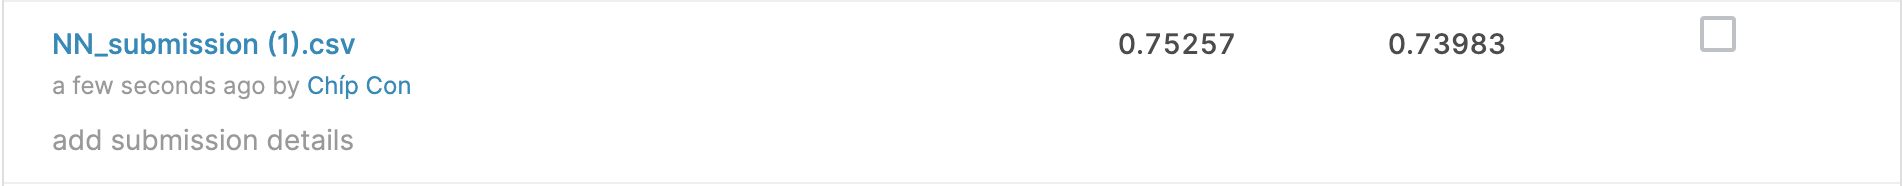

In [ ]:
from IPython import display
display.Image("kaggle_NN_submission.png")

#### 1.5.5 Kết luận.
- Kết quả của mô hình vẫn chưa cao do các hệ số trong hàm nén ảnh và lấp ảnh vẫn chưa được phù hợp với 1 số ảnh.
- Do tập dữ liệu khá nhỏ dẫn đến mô hình có thể đã bị trường hợp overfitting.

## 2. Sử dụng CNN với các convolution layer trích xuất dữ liệu và dense layer để huấn luyện dự đoán.

### 2.1 Đọc dữ liệu ảnh vào hai tập train và test

In [ ]:
# hàm đọc dữ liệu ảnh
def readImagesData(df, size_image):
    data_image = []
    image_ids = df['image_id']
    for image_id in image_ids:
        name = "images/" + image_id + ".jpg"
        image = cv.imread(name)
        im_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        im_rgb = cv.resize(im_rgb, (size_image, size_image))
        data_image.append(im_rgb)
    
    return np.array(data_image)   

In [ ]:
# Vì ảnh có kích thước rất lớn nên phải resize ảnh về 128 x 128
image_size = 128

In [ ]:
# Đọc các images dùng để train
train_images = readImagesData(train_table, image_size)

In [ ]:
# Đọc các images dùng để test
test_images = readImagesData(test_table, image_size)

In [ ]:
# Refresh miền giá trị pixel thành float
X_train = train_images
X_test = test_images
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# Chuẩn hoá các pixel trong ảnh
X_train /= 255
X_test /= 255

In [ ]:
Y_train = train_table[['healthy', 'multiple_diseases', 'rust', 'scab']]

#### 2.2 Hiện thực model CNN với các layer convolution để trích xuất và layer dense để huấn luyện dự đoán.

In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
model = Sequential()

# Các layer convolution để trích xuất dữ liệu từ ảnh
model.add(Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(image_size, image_size, 3)))#, kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Conv2D(64, kernel_size=(5,5),activation='relu'))#,kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(Dropout(.25))

model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))#,kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))#,kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(Dropout(.25))

model.add(Conv2D(64, kernel_size=(5,5),activation='relu'))#, kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Conv2D(128, kernel_size=(5,5),activation='relu',))#kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(Dropout(.25))

model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))#,kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))#,kernel_regularizer=l2(reg)))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(Dropout(.25))

# layer dense dùng để huấn luyện và dự đoán với hàm activation là relu
model.add(Flatten())
model.add(Dense(300,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(200,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))

# output layer với activation là softmax
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#### 2.3 Thực hiện train model trên GPU

In [ ]:
  with tf.device('/device:GPU:0'):
    model.fit(X_train, Y_train, epochs= 40, verbose=1,use_multiprocessing=False, shuffle=True)

Epoch 1/40
57/57 [==============================] - 61s 86ms/step - loss: 1.9238 - accuracy: 0.3040
Epoch 2/40
57/57 [==============================] - 4s 64ms/step - loss: 1.4704 - accuracy: 0.4020
Epoch 3/40
57/57 [==============================] - 4s 64ms/step - loss: 1.3597 - accuracy: 0.4295
Epoch 4/40
57/57 [==============================] - 4s 64ms/step - loss: 1.3039 - accuracy: 0.4507
Epoch 5/40
57/57 [==============================] - 4s 64ms/step - loss: 1.2793 - accuracy: 0.4492
Epoch 6/40
57/57 [==============================] - 4s 64ms/step - loss: 1.1532 - accuracy: 0.5365
Epoch 7/40
57/57 [==============================] - 4s 64ms/step - loss: 1.0595 - accuracy: 0.5812
Epoch 8/40
57/57 [==============================] - 4s 63ms/step - loss: 0.9328 - accuracy: 0.6279
Epoch 9/40
57/57 [==============================] - 4s 63ms/step - loss: 0.8489 - accuracy: 0.6844
Epoch 10/40
57/57 [==============================] - 4s 63ms/step - loss: 0.7402 - accuracy: 0.7015
Epoch 11

#### 2.4 Dự đoán tập test đã được lọc và lưu xuống tập submission

In [ ]:
Y_test = model.predict(X_test)
submission = pd.DataFrame(Y_test, columns = ['healthy', 'multiple_diseases', 'rust', 'scab'])
submission['image_id'] = test_table['image_id']
submission = submission[['image_id','healthy', 'multiple_diseases', 'rust', 'scab']]
submission.to_csv('CNN_submission.csv',index=False)

#### 2.5 Nộp kết quả lên trang kagle

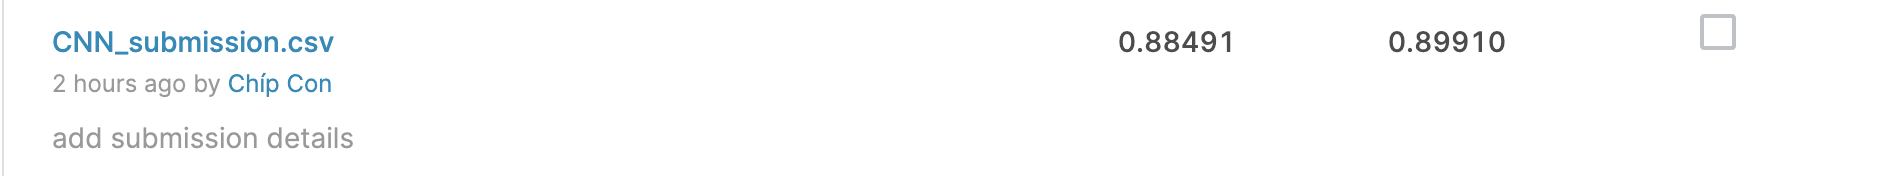

In [ ]:
from IPython import display
display.Image("kaggle_CNN_submission.png")

#### 2.6 Kết luận về model.
- Kết quả của model CNN tốt hơn hẳn so với model NN.
- Do có nhiều layer convolution nên kết quả dữ liệu được trích xuất tốt hơn là trích xuất thủ công như ở model NN.
- Và là trích xuất trực tiếp từ các phép tích chập nên thông tin được trích xuất chính xác và dẫn đến model đã dự đoán tốt hơn